In [1]:
#import astropy fits
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

IMPORTING THE DATA

In [101]:
catalog_voss_class="VOSS_classifications.fits"
catalog_AllWise="AllWISE.fits"
catalog_Gaia_EDR3="Gaia_EDR3.fits"
catalog_panstarrs="PanSTARRS1DR2.fits"


df_voss=pd.DataFrame()
df_AllWise=pd.DataFrame()
df_Gaia_EDR3=pd.DataFrame()
df_panstarrs=pd.DataFrame()


#why are some columns 2D arrays? I just reshape them to 1D.

#reading the catalogs and saving them to dataframes

def read_fits(catalog,df,removestrings=True):
    """ Reads a fits catalog and saves it to a dataframe. If removestrings is 
    True, it removes columns with string data type. """
    with fits.open(catalog) as data:
        columns=(data[1].columns)
        dimension=data[1].data[columns[0].name].shape[0]
        for c in columns:
            if data[1].data[c.name].shape==(dimension, 1):
                datacol=data[1].data[c.name][:,0]
            else:datacol=data[1].data[c.name]
            if removestrings and datacol.dtype.kind=='U': 
                print("removed ",c.name)
                continue
            elif datacol.dtype.kind=='U': df[c.name]=np.asarray(datacol)
            else:df[c.name]=np.asarray(datacol).byteswap().newbyteorder('<')
    return df

df_voss=read_fits(catalog_voss_class,df_voss,removestrings=False)
df_AllWise=read_fits(catalog_AllWise,df_AllWise)
df_Gaia_EDR3=read_fits(catalog_Gaia_EDR3,df_Gaia_EDR3)
df_panstarrs=read_fits(catalog_panstarrs,df_panstarrs)





removed  source_id
removed  var_flg
removed  objName
removed  source_id
removed  var_flg


### Crossmatching

 

In [125]:
def crossmatch(df1,df2,ra_key1="ra",dec_key1="dec",ra_key2="ra",dec_key2="dec"):
    cat1 = SkyCoord(ra=df1[ra_key1].to_numpy()*u.degree, dec=df1[dec_key1].to_numpy()*u.degree)
    cat2=SkyCoord(ra=df2[ra_key2].to_numpy()*u.degree, dec=df2[dec_key2].to_numpy()*u.degree)
    idx, d2d, d3d = cat1.match_to_catalog_sky(cat2)
    return idx,d2d,d3d

def combine_data_frames(dfvoss,df,ra_key1="RAd",dec_key1="DECd",ra_key2="ra",dec_key2="dec",
    max_sep=np.inf,df_columns=["ra","dec"]):

    idx,d2d,d3d=crossmatch(dfvoss,df,ra_key1,dec_key1,ra_key2,dec_key2)
    dfvoss=dfvoss.assign(idx_temp=idx)
    dfvoss=dfvoss[d2d<max_sep]
    df=df[df_columns]
    df=df.assign(idx_temp=np.arange(len(df)))
    df=pd.merge(dfvoss,df,on="idx_temp",how="left")
    df=df.drop(columns=["idx_temp"])
    return df


In [151]:
dfc=combine_data_frames(df_voss,df_AllWise,max_sep=0.7*u.arcsec,df_columns=["w1mpro","w2mpro","w3mpro","w4mpro"])
dfc=combine_data_frames(dfc,df_Gaia_EDR3,max_sep=0.7*u.arcsec,df_columns=["phot_g_mean_mag","phot_bp_mean_mag","phot_rp_mean_mag","parallax","parallax_error","pmra","pmdec","pmra_error","pmdec_error"])
dfc=combine_data_frames(dfc,df_panstarrs,max_sep=0.7*u.arcsec,ra_key2="raStack",dec_key2="decStack",df_columns=["gPSFMag","rPSFMag","iPSFMag","zPSFMag","yPSFMag"])

In [ ]:
dfc.head()

In [153]:
#save dfc
dfc.to_csv("combinedcat.csv")

Some visualisations

In [134]:
idx_allwise, d2d_allwise, d3d_allwise = crossmatch(df_voss,df_AllWise,ra_key2="ra",dec_key2="dec",ra_key1="RAd",dec_key1="DECd")

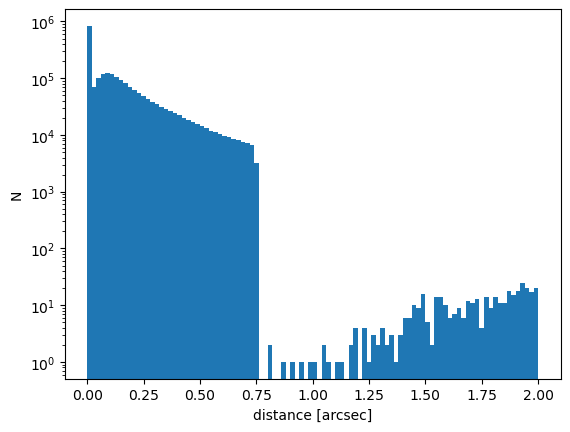

In [147]:
plt.hist(d2d_allwise.to(u.arcsec),bins=100,range=(0,2))
plt.yscale("log")
plt.xlabel("distance [arcsec]")
plt.ylabel("N")
plt.savefig("hist_allwise.png")

In [145]:
#same for pansstarrs
idx_panstarrs, d2d_panstarrs, d3d_panstarrs = crossmatch(df_voss,df_panstarrs,ra_key2="raStack",dec_key2="decStack",ra_key1="RAd",dec_key1="DECd")

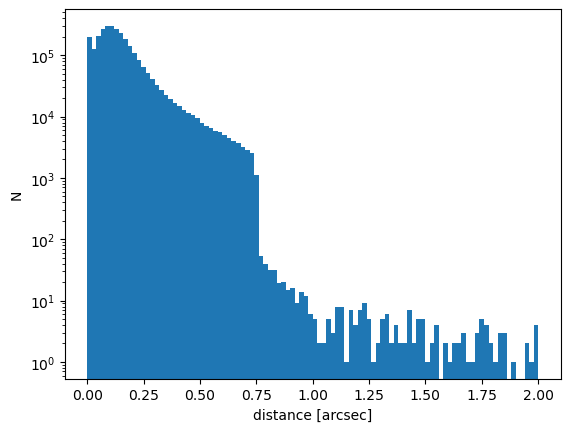

In [148]:
plt.hist(d2d_panstarrs.to(u.arcsec),bins=100,range=(0,2))
plt.yscale("log")
plt.xlabel("distance [arcsec]")
plt.ylabel("N")
plt.savefig("hist_panstarrs.png")


In [141]:
#same for gaia
idx_gaia, d2d_gaia, d3d_gaia = crossmatch(df_voss,df_Gaia_EDR3,ra_key2="ra",dec_key2="dec",ra_key1="RAd",dec_key1="DECd")

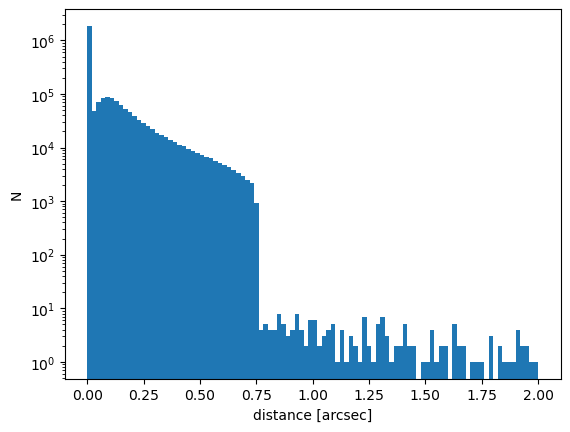

In [149]:
plt.hist(d2d_gaia.to(u.arcsec),bins=100,range=(0,2))
plt.yscale("log")
plt.xlabel("distance [arcsec]")
plt.ylabel("N")
plt.savefig("hist_gaia.png")
